# Download Updated Content from Autodesk Construction Cloud 

This sample shows how to automate and schedule the refresh of content from Autodesk Construction Cloud (ACC) using Python and Flask.

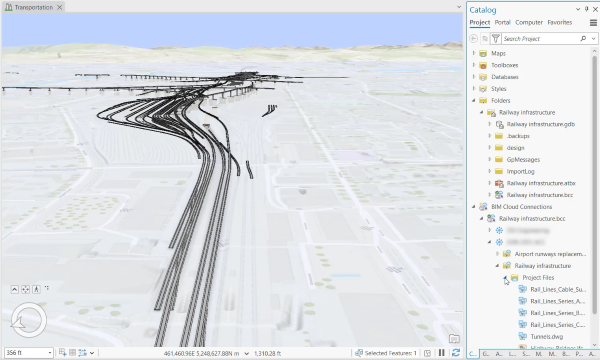
## Use case 
Project and asset managers need timely access to up-to-date design data for tracking progress and resolving issues. The BIM Cloud Connection in ArcGIS Pro lets you download CAD and BIM content from ACC to include in your project. This sample lets you schedule automated refreshes for documents stored in ACC using Python and Flask.

## Requirements

- Before continuing with the exercise, the user is expected to have used ArcGIS Pro to connect to BIM Cloud Connection to create an Autodesk Source File Manifest (ASFM) file. See https://pro.arcgis.com/en/pro-app/latest/help/data/cad/accessing-cad-data-from-cloud-connections.htm for more information. 
- Please have an ASFM on disk before continuing with the exercise.
- The user is also expected to have basic familiarity using Python and a Jupyter Notebook, as well as basic HTTP request knowledge.
- Additionally, please download the [Flask](https://pypi.org/project/Flask/) and [Requests](https://pypi.org/project/requests/) library using the following command: `python -m pip install flask requests`.

## How to use the sample 

### Step 1: Register an Application with Autodesk Platform Service

The first step is to register a web app Autodesk Platform Service (APS). 

While following the tutorial, register a "Traditional Web App". Once you have a set of CLIENT_ID and CLIENT_SECRET as well as the redirect URL setup, return to this notebook and proceed to the next step.

Follow the tutorial at https://get-started.aps.autodesk.com until the "Provision access in other products" section to set up your application.

### Step 2: Authenticate with APS to exchange for an access token

The next step is to perform 3-legged authentication with APS for an authentication code and exchange the code for an access token. The following code setups a Flask application to authenticate with APS.

In [ ]:
import requests
import json
from flask import Flask, request, redirect

Replace the following CLIENT_ID and CLIENT_SECRET with your application's CLIENT_ID and CLIENT_SECRET from Step 1.

In [ ]:
CLIENT_ID = 'YOUR_CLIENT_ID'
CLIENT_SECRET = 'YOUR_CLIENT_SECRET'

Ensure the redirect URI from Step 1 matches the following URI. If you used a different URI, change it, else leave it unchanged. 

In [ ]:
REDIRECT_URI = 'http://localhost:8080/api/auth/callback'

The next cell creates a new Flask application object, and configures it to listen on the 8080 port. While the Flask app is running, the kernel will remain busy. 

In [ ]:
app = Flask(__name__)
SCOPE = 'data:read'

@app.route('/')
def authenticate():
    return redirect(f"https://developer.api.autodesk.com/authentication/v2/authorize?response_type=code&client_id={CLIENT_ID}&redirect_uri={REDIRECT_URI}&scope={SCOPE}")

@app.route('/api/auth/callback', methods=['POST','GET'])
def callback():
    # Get authentication code from the GET parameters. (The authentication code is needed to refresh the access token in Appendix A)
    code = request.args.get('code')
    payload = f"grant_type=authorization_code&code={code}&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&redirect_uri={REDIRECT_URI}"

    # Exchange for access token
    tokenUrl = "https://developer.api.autodesk.com/authentication/v2/token"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    response = requests.request("POST", tokenUrl, data=payload, headers=headers).json()
    
    return json.dumps(response, indent=2), 200

if __name__ == '__main__':
    # Start the app and listen for requests on port 8080
    app.run(port=8080) 
    

Now that the Flask application is running (the kernel should remain busy), open a web browser and enter the following address: http://localhost:8080/. You should be redirected to Autodesk's authentication page. After entering your credentials, you will be redirected back to the callback URL you defined in Step 1 with an `access_token` and a `refresh_token`.

Store the `access_token` and the `refresh_token` in the variables below. Additionally, store the authentication code within the callback function to refresh the `access_token` later (see Appendix A). Now you can interrupt the kernel to terminate the Flask app. 

For more information about using Python and Flask to perform a three-legged token exchange, see https://aps.autodesk.com/blog/three-legged-token-python-and-flask.

In [ ]:
access_token = "YOUR_ACCESS_TOKEN"
refresh_token = "YOUR_REFRESH_TOKEN"

### Step 3: Create a function to check for updates from BIM 360

To check if a file has been updated on BIM 360, you will need the `project_id`, `item_id` and the current version of the file on disk. All required information is stored inside an Autodesk Source File Manifest (ASFM) file on disk. The following demonstrates how to open an existing ASFM file and retrieve the `project_id`, `item_id`, and current version of the file.

First, replace the following variable with the file path to the ASFM file on disk.

In [ ]:
file_path = r"dir\path_to_file.asfm"

Next, run the following cell, which will read the ASFM file into memory.

In [ ]:
import json

# Read the ASFM file as a JSON object
f = open(file_path, "r")
asfm = json.loads(f.read())
f.close()

# Hold onto information to be used later
project_id = asfm["ProjectId"]
item_id = asfm["ItemId"]
local_version = int(asfm["Version"])

The next step is to use the `access_token` along with the `project_id` and `item_id` to retrieve the item metadata from APS and compare against the current file version.

In [ ]:
import requests

metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Authorization": f"Bearer {access_token}"
}

metadata = requests.request("GET", metadata_url, headers=headers).json()
cloud_version = metadata["included"][0]["attributes"]["versionNumber"]

If the `cloud_version` is newer, then we will need to update the file locally. 

Combining the above generates the following function, which will be used in a later step:

```Python
def needs_update(file_path):
    # Get the local file version
    f = open(file_path, "r")
    asfm = json.loads(f.read())
    f.close()

    project_id = asfm["ProjectId"]
    item_id = asfm["ItemId"]
    local_version = int(asfm["Version"])

    # Get the cloud file version
    metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Bearer {access_token}"
    }
    
    metadata = requests.request("GET", metadata_url, headers=headers).json()
    cloud_version = metadata["included"][0]["attributes"]["versionNumber"]

    # Compare the two versions
    return cloud_version > local_version
```


### Step 4: Create a function to download file from BIM 360

If BIM 360 has a newer versioned file, then you will need to download the file from BIM 360. The following shows how to retrieve the item metadata using the `project_id`, `item_id`, and `access_token`.

In [ ]:
metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Authorization": f"Bearer {access_token}"
}

metadata = requests.request("GET", metadata_url, headers=headers).json()

After downloading the item metadata, you can retrieve the storage URL and exchange it for a download URL.

In [ ]:
# Retrieve the storage url from the item metadata
storage_url = metadata["included"][0]["relationships"]["storage"]["meta"]["link"]["href"]

# Remove any GET parameters from the URL
if storage_url.find('?'):
    storage_url = storage_url[:storage_url.find('?')]

# Gets a short-lived signed URL at which you can download an object directly from Amazon S3, bypassing OSS servers.
storage_url = storage_url + "/signeds3download"
item = requests.request("GET", storage_url, headers=headers).json()

download_url = item["url"]

The next part shows how to use the `download_url` to download the file, overwriting the existing file on disk.

In [ ]:
import os 
import shutil

path = os.path.join(".", asfm["SourceFileName"])

# Get the response as a byte stream
download = requests.request("GET", download_url, stream=True)

# Redirect the data from the byte stream into a local file stream
with open(path, 'wb') as out_file:
    shutil.copyfileobj(download.raw, out_file)

Combining the above creates the following function, which will be used in a later step:

```Python
def update_file(file_path):
    # Get the local file path
    f = open(file_path, "r")
    asfm = json.loads(f.read())
    f.close()

    project_id = asfm["ProjectId"]
    item_id = asfm["ItemId"]
    path = os.path.join(".", asfm["SourceFileName"])

    # Get the item metadata
    metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Bearer {access_token}"
    }
    
    # Retrieve the storage url from the item metadata
    storage_url = metadata["included"][0]["relationships"]["storage"]["meta"]["link"]["href"]
    
    # Remove any GET parameters from the URL
    if storage_url.find('?'):
        storage_url = storage_url[:storage_url.find('?')]
    
    # Gets a short-lived signed URL at which you can download an object directly from S3, bypassing OSS servers.
    storage_url = storage_url + "/signeds3download"
    item = requests.request("GET", storage_url, headers=headers).json()
    
    # Get the response as a byte stream
    download = requests.request("GET", download_url, stream=True)

    # Redirect the data from the byte stream into a local file stream
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(download.raw, out_file)
```

After downloading the updated file from APS, remember update the local file version in the ASFM file. 

In [ ]:
asfm["Version"] = cloud_version

# Write the updated JSON object back to the ASFM file
with open(file_path, 'w') as out_file:
    json.dump(asfm, out_file)

### Step 5 (final): Create and schedule a Python script to automatically update downloaded BIM 360 files

This is the final step to creating a Python script that can download updated BIM 360 files from APS. We can combine the Python functions at the end of Step 3 and Step 4 to generate a Python script, like the one seen below:


In [ ]:
import os
import shutil
import json
import requests

# Replace the following three variables
access_token = "YOUR_ACCESS_TOKEN"
refresh_token = "YOUR_REFRESH_TOKEN"
asfm_files = [r"dir/path_to_file1.asfm", r"dir/path_to_file2.asfm"]

def needs_update(file_path):
    # Get the local file version
    f = open(file_path, "r")
    asfm = json.loads(f.read())
    f.close()

    project_id = asfm["ProjectId"]
    item_id = asfm["ItemId"]
    local_version = int(asfm["Version"])

    # Get the cloud file version
    metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Bearer {access_token}"
    }
    
    metadata = requests.request("GET", metadata_url, headers=headers).json()
    cloud_version = metadata["included"][0]["attributes"]["versionNumber"]

    # Compare the two versions
    return cloud_version > local_version

def update_asfm_version(file_path):
    # Get the local file version
    f = open(file_path, "r")
    asfm = json.loads(f.read())
    f.close()
    
    project_id = asfm["ProjectId"]
    item_id = asfm["ItemId"]
    
    # Get the cloud file version
    metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Bearer {access_token}"
    }

    metadata = requests.request("GET", metadata_url, headers=headers).json()
    cloud_version = metadata["included"][0]["attributes"]["versionNumber"]

    asfm["Version"] = str(cloud_version)
    
    # Write the updated JSON object back to the ASFM file
    with open(file_path, 'w') as out_file:
        json.dump(asfm, out_file)

def update_file(file_path):
    # Get the local file path
    f = open(file_path, "r")
    asfm = json.loads(f.read())
    f.close()

    project_id = asfm["ProjectId"]
    item_id = asfm["ItemId"]
    path = os.path.join(".", asfm["SourceFileName"])

    # Get the item metadata
    metadata_url = f"https://developer.api.autodesk.com/data/v1/projects/{project_id}/items/{item_id}"
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Bearer {access_token}"
    }
    
    # Retrieve the storage url from the item metadata
    storage_url = metadata["included"][0]["relationships"]["storage"]["meta"]["link"]["href"]
    
    # Remove any GET parameters from the URL
    if storage_url.find('?'):
        storage_url = storage_url[:storage_url.find('?')]
    
    # Gets a short-lived signed URL at which you can download an object directly from S3, bypassing OSS servers.
    storage_url = storage_url + "/signeds3download"
    item = requests.request("GET", storage_url, headers=headers).json()
    
    # Get the response as a byte stream
    download = requests.request("GET", download_url, stream=True)

    # Redirect the data from the byte stream into a local file stream, overwriting the existing file on disk
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(download.raw, out_file)

if __name__ == "__main__":
    for asfm_file in asfm_files:
        if needs_update(asfm_file):
            update_file(asfm_file)
            update_asfm_version(asfm_file)
            

You may add additional ASFM files inside the list `asfm_files` as needed to iterate over all existing ASFM files. For convenience, the content in the above cell can be copied into and executed as stand-alone Python script with minimal modification. 

Now you can use [Windows Task Scheduler](https://learn.microsoft.com/en-us/windows/win32/taskschd/task-scheduler-start-page) or your preferred scheduler application to schedule the Python script to update the downloaded BIM 360 files at a specified time. Happy automating!

### Appendix A

Access tokens can expire. If expired, you can use the authentication code and refresh token to request a new access token. Strategies to ensure the access token is unexpired are outside the scope of this Jupyter Notebook, but the refresh token and the authentication code can be used to exchange for a new access token and refresh token as demonstrated below:

In [ ]:
code = 'YOUR_AUTHENTICATION_CODE'

refresh_url = f"https://developer.api.autodesk.com/authentication/v2/token"
payload = f"client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&refresh_token={refresh_token}&code={code}&grant_type=refresh_token"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Authorization": f"Bearer {access_token}"
}

response = requests.request("POST", refresh_url, data=payload, headers=headers).json()